In [12]:
# Regular python libraries
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Standar bokeh libraries
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import LinearAxis, Range1d  # Handle two y axis
from bokeh.models import CheckboxGroup, CustomJS
from bokeh.layouts import row, column, widgetbox
import warnings
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

## Cleaning Data

In [13]:
acc_min = -8
acc_max = 8
ap_min = -110
ap_max = 0

In [14]:
# Read data (from file or DB)
df = pd.read_csv('acceleration.csv',#../Dataset/train/00001/acceleration.csv',# skiprows=5, na_values=NaN,
    sep=',')
#df.head()

### Filtering

In [15]:
dfa = df.copy()
len_before = len(dfa.index)
dfz = dfa[((dfa.x > acc_min) < acc_max)][((dfa.y > acc_min) < acc_max)][((dfa.z > acc_min) < acc_max)]\
[((dfa.Kitchen_AP < ap_max) & (dfa.Kitchen_AP > ap_min)) | dfa.Kitchen_AP.isnull()]\
[((dfa.Lounge_AP < ap_max) & (dfa.Lounge_AP > ap_min)) | dfa.Lounge_AP.isnull()]\
[((dfa.Upstairs_AP < ap_max) & (dfa.Upstairs_AP > ap_min)) | dfa.Upstairs_AP.isnull()]\
[((dfa.Study_AP < ap_max) & (dfa.Study_AP > ap_min)) | dfa.Study_AP.isnull()]\
[(dfa.t > 0) & (dfa.t < 30 * 60 * 20)]
len_after = len(dfz.index)
if len_before != len_after:
    print('There were outranged data')
else:
    print('Same!')


Same!


In [16]:
dfz.head()

,t,x,y,z,Kitchen_AP,Lounge_AP,Upstairs_AP,Study_AP
0,0.017856,0.944,-0.280,0.152,-93.0,-95.0,-79.0,NaN
1,0.067904,0.944,-0.292,0.156,-93.0,-95.0,-79.0,NaN
2,0.117952,0.946,-0.286,0.156,-93.0,-95.0,-79.0,NaN
3,0.168000,0.942,-0.288,0.160,-93.0,-95.0,-79.0,NaN
4,0.217856,0.946,-0.286,0.158,-90.0,-89.0,-79.0,NaN


### Setting column 't' as timedeltaindex

In [17]:

dfb = dfz.copy()
dfb['t'] = pd.to_timedelta(dfb['t'],unit='s')
dfb = dfb.set_index(pd.TimedeltaIndex(dfb['t']))
del dfb['t']
len(dfb)

35710

In [18]:
#dfb[14830:14857]
#dfb.plot()

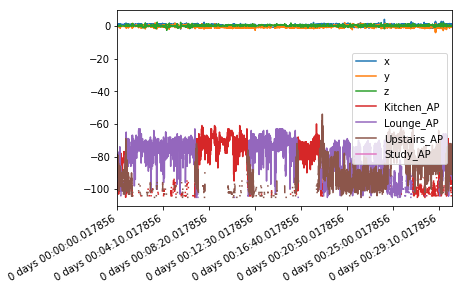

In [19]:
sampleps = 20
freq = str(int(1000/sampleps))+'L'
dfc = dfb.resample(freq).pad()
dfb = dfc.copy()
len(dfc)
dfb.plot( x_compat=True)

In [20]:
#np.sqrt(dfb.x.values**2 + dfb.y.values**2 + dfb.z.values**2)

In [21]:
line = pd.Series(np.sqrt(dfb.x.values**2 + dfb.y.values**2 + dfb.z.values**2), index=dfb.index) # Euclidean

In [22]:
#line.plot()

In [23]:
#del(dfb.w)
#del(dfb['w'])

In [24]:
dfb['w'] = line * 9.81 # to m/s*s

In [25]:
#dfb[['x','y','z','w']].plot()

In [26]:
dfb.w[dfb.w < 0]

Series([], Freq: 50L, Name: w, dtype: float64)

In [27]:
nano = 1000000000
t0 = int(dfb.index.values[0])/nano
t0

0.017856

In [28]:
d0 = dfb.w[0] * t0**2
dfb.w[0]

9.7738325289519885

In [29]:
d0

0.0031162568617416776

In [30]:
line[0] * 9.81

9.7738325289519885

In [31]:
v0 = d0/t0

In [32]:
v0

0.1745215536369667

In [33]:
v0f = dfb.w[0] * t0
v0f

0.1745215536369667

In [34]:
d1 = (v0 + (dfb.w[1]-dfb.w[0])*(int(dfb.index.values[1])/nano - int(dfb.index.values[0])/nano))\
     * (int(dfb.index.values[1])/nano - int(dfb.index.values[0])/nano)
d1

0.0087260776818483352

In [35]:
t1 = int(dfb.index.values[1])/nano
t1

0.067856

In [36]:
v1 = d1 / (t1-t0)
v1

0.1745215536369667

In [37]:
v1f = v0 + (dfb.w[1]-dfb.w[0])*(int(dfb.index.values[1])/nano - int(dfb.index.values[0])/nano)
v1f

0.1745215536369667

In [38]:
v = np.empty(len(dfb))
d = np.empty(len(dfb))

In [39]:
for i in range(len(dfb)):
    if i == 0:
        d[i] = dfb.w[i] * (int(dfb.index.values[i])/nano)**2
        v[i] = d[i] / (int(dfb.index.values[i])/nano)
    else:
        d[i] = (v[i-1] + (dfb.w[i]-dfb.w[i-1])*(int(dfb.index.values[i])/nano - int(dfb.index.values[i-1])/nano))\
               * (int(dfb.index.values[i])/nano - int(dfb.index.values[i-1])/nano)
        v[i] = d[i] / (int(dfb.index.values[i])/nano - int(dfb.index.values[i-1])/nano)
        

327.05073378042761

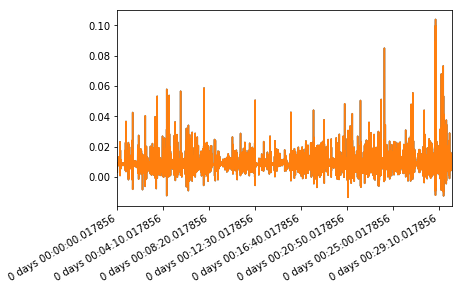

In [40]:
distance = pd.Series(d, index = dfb.index)
distance.plot(x_compat=True)
distance.plot()
distance.sum()

In [41]:
dfb.x[distance[distance > 100].index]

Series([], Freq: 50L, Name: x, dtype: float64)

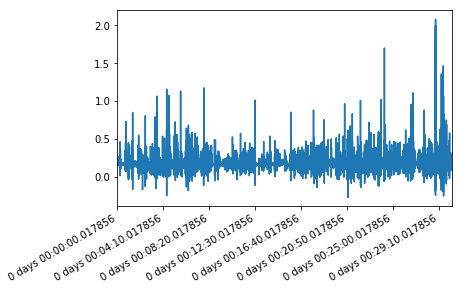

In [42]:
velocity = pd.Series(v, index = dfb.index)
velocity.plot(x_compat=True)